In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

import nc_time_axis
import cftime
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from cmocean import cm as cmo

import gsw
from GG_mthesis import utils as utils

%matplotlib inline

In [2]:
import os
os.chdir('C:\\Users\\gian_\\repos\\mthesis_gianlucca')
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

In [3]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_transect.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

In [4]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')

In [5]:
#First I am going to exclude all the data where the distance is less than 240 m (explanation in fun_with_boat_speed notebook).
#Let's calculate the cumulative distance between sampling points (starting at 0) and introduce it as a coordinate variable in the dataset
distance = gsw.distance(np.array(ds.lon), np.array(ds.lat))
distance_cum = np.insert(np.cumsum(distance), 0, 0)
ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})
ds = ds.set_coords('distance_cum')
ds['distance_cum'].attrs = {
    'long_name': 'Cumulative distance',
    'standard_name': 'distance_cum',
    'units': 'm',
    'description': 'cumulative distance between sampling points calculated using gsw'
}

#Auxiliary distance variable for data selection
distance_aux = np.insert(distance, 0, 999)
ds['distance_aux'] = xr.DataArray(distance_aux,dims={'time':ds.time},coords={'time':ds.time})
ds['distance_aux'].attrs = {
    'long_name': 'Auxiliary distances',
    'standard_name': 'distance_aux',
    'units': 'm',
    'description': 'Auxiliary variable composed of the distances between datapoint with an additional point inserted as the first value, being the median. This is in order to be able to sample out of the dataset acroding to the distance. That way, e.g., if one wanted to sample all values with a distance greater than 200m, the reaching point of each distance sample would be excluded.'
}

#Actual data selection
ds = ds.where(ds.distance_aux >= 240)

#Now we can drop the auxiliary distance variable again.
ds = ds.drop('distance_aux')

In [6]:
#I am going to work with temperature (and we have decided to use the TSG temperature for now) and salinity (calibrated). I am going to drop of the variables I do not need. I also rename salinity and temperature.
#POT_TEMP --> LOOK AT WORKING NOTES
ds = ds.drop(['attenuation','conductivity_tsg','chl-a','sal_tsg_nocal','temp_hull_1','temp_hull_2']).rename({'sal_tsg_cal':'SP', 'temp_cond_tsg':'PT'})

In [7]:
#I calculate the pressure, absolute salinity and conservative temperture usign gsw. 
ds['press'] = gsw.p_from_z(-ds.depth, ds.lat)
ds['press'].attrs = {
    'long_name': 'Pressure',
    'standard_name': 'press',
    'units': 'dbar',
    'description': 'Sea pressure from height using gsw.'}

ds['SA'] = gsw.SA_from_SP(ds.SP, ds.press, ds.lon, ds.lat)
ds['SA'].attrs = {
    'long_name': 'Absolute Salinity',
    'standard_name': 'CT',
    'units': 'g/kg',
    'description': 'Absolute salinity from practical salinity using gsw.'}

ds['CT'] = gsw.CT_from_pt(ds.SA, ds.PT)
ds['CT'].attrs = {
    'long_name': 'Conservative Temperture',
    'standard_name': 'CT',
    'units': '°C',
    'description': 'Conservative temperature from potential temperature using gsw.'}

In [8]:
#I calculate the density
ds['rho'] = gsw.rho(ds.SA,ds.CT,ds.press)
ds['rho'].attrs = {
    'long_name': 'In-situ density',
    'standard_name': 'rho',
    'units': 'kg/m3',
    'description': 'In-situ density calculated using gsw.'
}

ds['rho_pot'] = gsw.rho(ds.SA,ds.CT,0)
ds['rho_pot'].attrs = {
    'long_name': 'Potential density',
    'standard_name': 'rho_pot',
    'units': 'kg/m3',
    'description': 'Potential density calculated using gsw.'
}

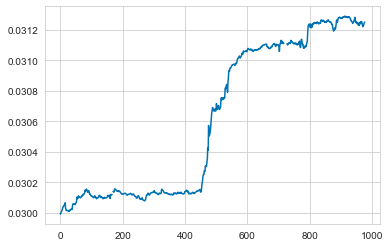

In [9]:
#quick plot of difference between density and potential density
plt.plot(ds.distance_cum/1000, ds.rho - ds.rho_pot)

In [10]:
#Here I create the distance grid I want to interpolate the data onto
distance_grid = np.arange(0, 975862, 500)

#Make the cumulative distance the dimension as I want to use it as the interpolating dimension
ds = ds.swap_dims({'time':'distance_cum'})

#Here I create new gridded dataset, one with a linear interpolation and another one with a cubic interpolation.
ds_gridded = ds.interp(distance_cum = distance_grid, method='linear')
ds_gridded_cubic = ds.interp(distance_cum = distance_grid, method='cubic')

In [11]:
ds_gridded.head()

<xarray.Dataset>
Dimensions:       (distance_cum: 5)
Coordinates:
    lat           (distance_cum) float64 -52.5 -52.51 -52.51 -52.51 -52.52
    lon           (distance_cum) float64 -58.17 -58.17 -58.17 -58.17 -58.17
    depth         (distance_cum) float64 6.5 6.5 6.5 6.5 6.5
  * distance_cum  (distance_cum) int32 0 500 1000 1500 2000
Data variables:
    SP            (distance_cum) float64 33.69 33.69 33.7 33.7 33.7
    PT            (distance_cum) float64 7.405 7.413 7.392 7.381 7.371
    press         (distance_cum) float64 6.558 6.558 6.558 6.558 6.558
    SA            (distance_cum) float64 33.85 33.85 33.85 33.85 33.86
    CT            (distance_cum) float64 7.416 7.424 7.403 7.392 7.382
    rho           (distance_cum) float64 1.026e+03 1.026e+03 ... 1.026e+03
    rho_pot       (distance_cum) float64 1.026e+03 1.026e+03 ... 1.026e+03
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

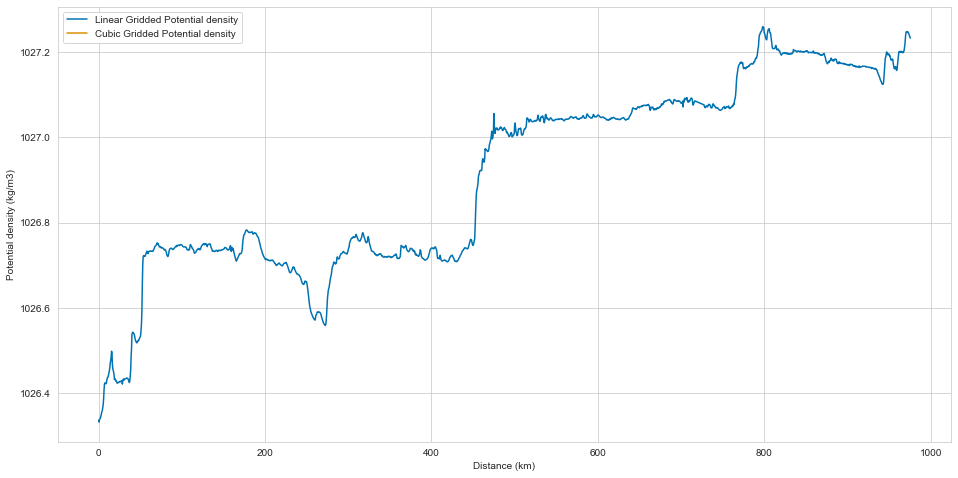

In [12]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(16,8))

sns.lineplot(x=ds_gridded.distance_cum/1000, y=ds_gridded.rho_pot, ax=ax0, label='Linear Gridded Potential density')
sns.lineplot(x=ds_gridded_cubic.distance_cum/1000, y=ds_gridded_cubic.rho_pot, ax=ax0, label='Cubic Gridded Potential density')
ax0.set(xlabel='Distance (km)', ylabel='Potential density (kg/m3)')
ax0.legend(loc='upper left')


In [13]:
rho_dif = []
for i in range(len(ds.distance_cum)-1):
    rho_dif.append(np.array(ds.rho_pot[i+1]) - np.array(ds.rho_pot[i]))
rho_dif = np.array(rho_dif)

In [14]:
rho_dif_gridded = []
for i in range(len(ds_gridded.distance_cum)-1):
    rho_dif_gridded.append(np.array(ds_gridded.rho_pot[i+1]) - np.array(ds_gridded.rho_pot[i]))
rho_dif_gridded = np.array(rho_dif_gridded)

In [15]:
distance

array([264.16194769, 302.8878596 , 326.2391122 , ..., 398.24645964,
       399.55532852, 401.54578855])

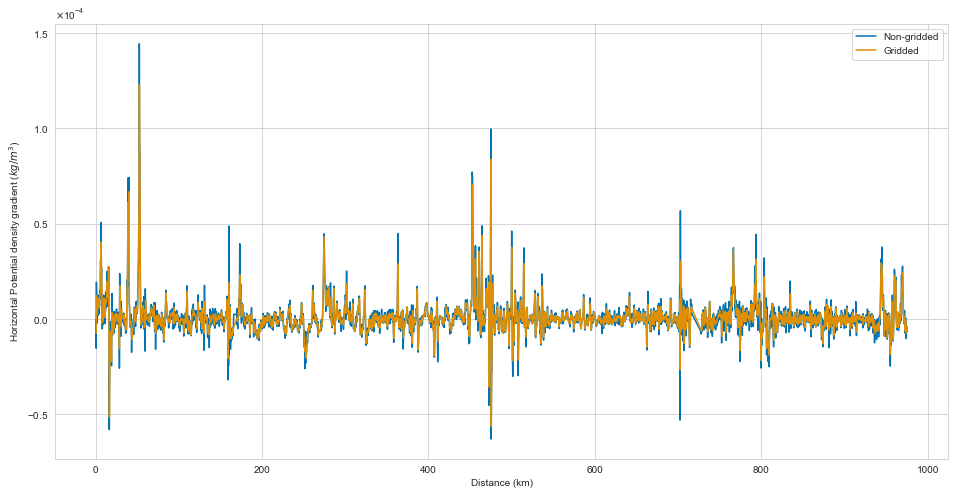

In [21]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(16,8))

sns.lineplot(x=ds.distance_cum[1:]/1000, y=rho_dif/distance, ax=ax0, label='Non-gridded')
sns.lineplot(x=ds_gridded.distance_cum[1:]/1000, y=rho_dif_gridded/500, ax=ax0, label='Gridded')
ax0.set(xlabel='Distance (km)', ylabel='Horizontal Potential density gradient ($kg/m^{3}$)')

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax0.yaxis.set_major_formatter(formatter) 

plt.savefig('C:\\Users\\gian_\\repos\\mthesis_gianlucca\\results\\preprocessing\\pot_grid_grdvsnogrid.png', bbox_inches='tight', format='png')

In [17]:
ds_gridded

<xarray.Dataset>
Dimensions:       (distance_cum: 1952)
Coordinates:
    lat           (distance_cum) float64 -52.5 -52.51 -52.51 ... -61.19 -61.2
    lon           (distance_cum) float64 -58.17 -58.17 -58.17 ... -57.09 -57.09
    depth         (distance_cum) float64 6.5 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5
  * distance_cum  (distance_cum) int32 0 500 1000 1500 ... 974500 975000 975500
Data variables:
    SP            (distance_cum) float64 33.69 33.69 33.7 ... 33.94 33.94 33.93
    PT            (distance_cum) float64 7.405 7.413 7.392 ... 0.3345 0.3232
    press         (distance_cum) float64 6.558 6.558 6.558 ... 6.563 6.563 6.563
    SA            (distance_cum) float64 33.85 33.85 33.85 ... 34.11 34.1 34.1
    CT            (distance_cum) float64 7.416 7.424 7.403 ... 0.3391 0.3279
    rho           (distance_cum) float64 1.026e+03 1.026e+03 ... 1.027e+03
    rho_pot       (distance_cum) float64 1.026e+03 1.026e+03 ... 1.027e+03
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [18]:
#Let's calculate the horizontal buoyancy gradient
g = 9.8 #m s-2
rho_ref = 1027 #kg m-3

bx = []
for i in range(len(ds_gridded.distance_cum)-1):
    bx.append((g/rho_ref)*((np.array(ds_gridded.rho_pot[i+1])-np.array(ds_gridded.rho_pot[i]))/1000))
bx = np.array(bx)

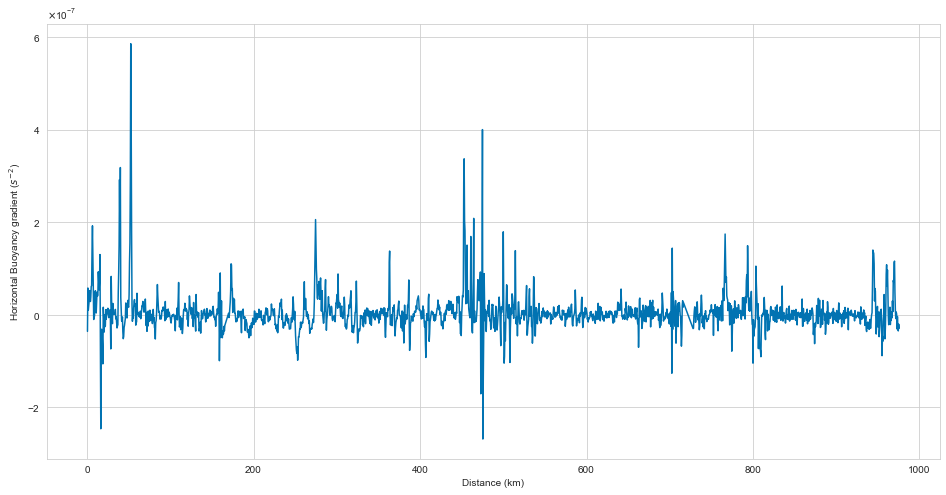

In [20]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(16,8))

sns.lineplot(x=ds_gridded.distance_cum[1:]/1000, y=bx, ax=ax0)
ax0.set(xlabel='Distance (km)', ylabel='Horizontal Buoyancy gradient ($s^{-2}$)')

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax0.yaxis.set_major_formatter(formatter) 

plt.savefig('C:\\Users\\gian_\\repos\\mthesis_gianlucca\\results\\preprocessing\\bx_prelim.png', bbox_inches='tight', format='png')

In [22]:
ds_gridded

<xarray.Dataset>
Dimensions:       (distance_cum: 2726)
Coordinates:
    lat           (distance_cum) float64 -52.5 -52.5 -52.51 ... -61.19 -61.2
    lon           (distance_cum) float64 -58.17 -58.17 -58.17 ... -57.09 -57.09
    depth         (distance_cum) float32 6.5 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5
    time          (distance_cum) datetime64[ns] 2017-11-09T02:12:59.999680 ... 2017-11-10T23:37:59.997824
  * distance_cum  (distance_cum) float64 0.0 264.2 567.0 ... 9.755e+05 9.759e+05
Data variables:
    SP            (distance_cum) float32 33.695 33.69425 ... 33.934 33.9305
    PT            (distance_cum) float32 7.4051 7.40175 ... 0.3236 0.3199
    press         (distance_cum) float64 6.558 6.558 6.558 ... 6.563 6.563 6.563
    SA            (distance_cum) float64 33.85 33.85 33.85 ... 34.1 34.1 34.09
    CT            (distance_cum) float64 7.416 7.413 7.427 ... 0.3282 0.3245
    rho           (distance_cum) float64 1.026e+03 1.026e+03 ... 1.027e+03
    rho_pot       (distance_cum) float64 1.026e+03 1.026e+03 ... 1.027e+03
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...